In [28]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.src.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
import shutil

base_dir = 'Images'

train_dir = 'train'
test_dir = 'test'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(os.path.join(train_dir, 'glasses'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'no_glasses'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'glasses'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'no_glasses'), exist_ok=True)


def split_dataset(source_dir, train_dir, test_dir, split_ratio=0.5):
    for class_name in ['glasses', 'no_glasses']:
        source_class_dir = os.path.join(base_dir, class_name)
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)

        images = [
            img_name for img_name in os.listdir(source_class_dir)
            if os.path.isfile(os.path.join(source_class_dir, img_name)) and not img_name.startswith('.')
        ]
        random.shuffle(images)

        split_idx = int(len(images) * split_ratio)
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        for img_name in train_images:
            src_path = os.path.join(source_class_dir, img_name)
            dest_path = os.path.join(train_class_dir, img_name)
            shutil.copy(src_path, dest_path)

        for img_name in test_images:
            src_path = os.path.join(source_class_dir, img_name)
            dest_path = os.path.join(test_class_dir, img_name)
            shutil.copy(src_path, dest_path)

split_dataset(base_dir, train_dir, test_dir)


'''
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255)

def clean_checkpoints(directory):
    for root, dirs, _ in os.walk(directory):
        for dir_name in dirs:
            if dir_name == ".ipynb_checkpoints":
                shutil.rmtree(os.path.join(root, dir_name))
'''

'''
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)
'''

train_experiment = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=32,
)

test_experiment = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=32,
)
classnames_train = train_experiment.class_names
classnames_test = test_experiment.class_names
print(classnames_train, classnames_test)





Found 2459 files belonging to 2 classes.
Found 2461 files belonging to 2 classes.
['glasses', 'no_glasses'] ['glasses', 'no_glasses']


# Data visualisation


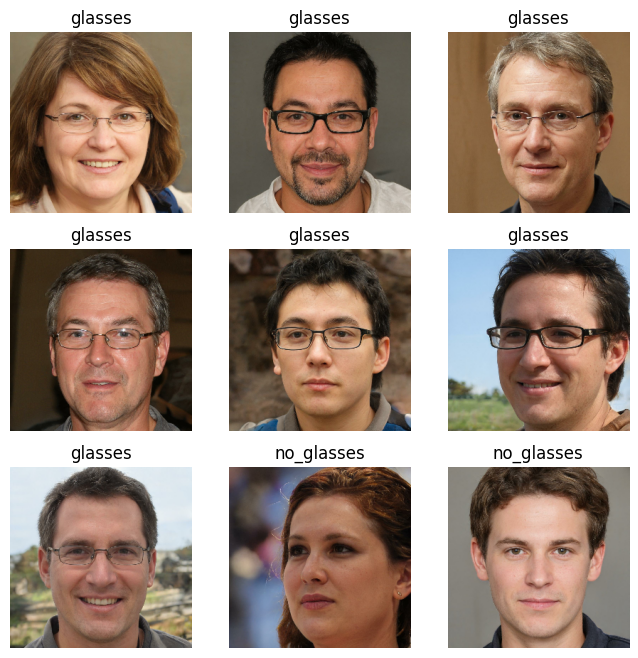

In [29]:
plt.figure(figsize=(8, 8))
for images, labels in train_experiment.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classnames_train[labels[i]])
        plt.axis("off")

# Data Optimisation

In [30]:
AUTOTUNE = tf.data.AUTOTUNE
'''
def directory_to_dataset(directory_iterator):
    dataset = tf.data.Dataset.from_generator(
        lambda: directory_iterator,
        output_signature=(
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )
    return dataset
'''
batch_size = 23
train_dataset = train_experiment.cache().shuffle(buffer_size=500).prefetch(buffer_size=3)
test_dataset = test_experiment.cache().prefetch(buffer_size=3)

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip(
        "horizontal"),

    tf.keras.layers.RandomRotation(
        0.1),
    tf.keras.layers.RandomZoom(
        0.1),
  ]
)

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5002 - loss: 1.3364 - val_accuracy: 0.5668 - val_loss: 0.6774
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.6366 - loss: 0.6324 - val_accuracy: 0.9651 - val_loss: 0.1170
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9308 - loss: 0.1709 - val_accuracy: 0.9927 - val_loss: 0.0403
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9674 - loss: 0.1036 - val_accuracy: 0.9951 - val_loss: 0.0178
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9782 - loss: 0.0634 - val_accuracy: 0.9947 - val_loss: 0.0198


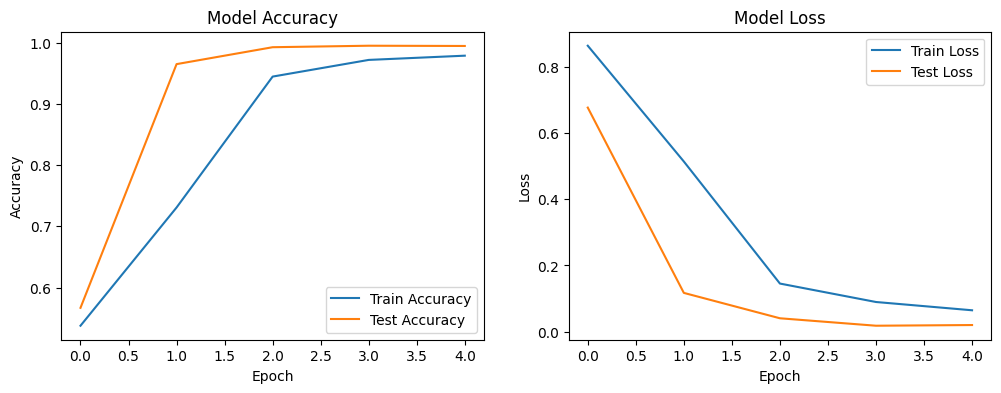

Modèle sauvegardé avec succès.


In [31]:

model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam",
              loss='binary_crossentropy', #tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
    #train_experiment,
    train_dataset,
    epochs=5,
    validation_data=test_dataset
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save("glasses_classification_model.keras")
print("Modèle sauvegardé avec succès.")
